<a href="https://colab.research.google.com/github/rpgit12/cs236/blob/main/AudioData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some usefule notes on MEL spectogram ...


https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0


In [ ]:
# pull repository
!git clone https://github.com/rpgit12/cs236.git

In [ ]:
# install pre-requisites
!pip install -r cs236/requirements.txt
!cat cs236/packages.txt | xargs sudo apt-get install -y

In [ ]:
# download subset of data set
!gsutil cp gs://paustian_cs236/maestro-v3.0.0-2017-v1.zip /content/
!cd /content & unzip -o /content/maestro-v3.0.0-2017-v1.zip

In [ ]:
# download a few checkpoints from training
!gsutil cp gs://paustian_cs236/checkpoint_199.tar /content/
!cd /content & tar xfv /content/checkpoint_199.tar

In [13]:
import os
import sys
import glob
import json
import pathlib
import IPython
import dataclasses
import pandas as pd
import music21 as m21
import matplotlib.pyplot as plt
import librosa as lr
import librosa.display
from midi2audio import FluidSynth
from tqdm.notebook import tqdm
from datetime import datetime
from torchsummary import summary

sys.path.insert(1, '/content/cs236')

from maestrodata import *
from mtransformer import *


In [6]:
random_state = np.random.RandomState(2021)
maestro_config = MaestroDatasetConfig()
maestro_config.root_dir = '/content/maestro-v3.0.0'
maestro_config.years = [2017]
# maestro_config.sec_per_sample = [1, 3]
# maestro_config.max_source_length = 129
# maestro_config.max_target_length = 800
maestro_data = MaestroData(maestro_config, random_state=random_state)

max_size = None
fixed_sample = False
include_meta_data = True
batch_size = 1

# these include meta data - don't use with pytorch as it contains data other than torch tensors
train_data_meta = MaestroDataset(maestro_data, batch_size=1, max_size=max_size, train=True, fixed_sample=fixed_sample, include_meta_data=include_meta_data)
valid_data_meta = MaestroDataset(maestro_data, batch_size=1, max_size=max_size, validation=True, fixed_sample=fixed_sample, include_meta_data=include_meta_data)

# standard data sets (same records)
train_data = MaestroDataset(maestro_data, batch_size=1, max_size=max_size, train=True, fixed_sample=fixed_sample, include_meta_data=False)
valid_data = MaestroDataset(maestro_data, batch_size=1, max_size=max_size, validation=True, fixed_sample=fixed_sample, include_meta_data=False)
train_generator = torch.utils.data.DataLoader(train_data, worker_init_fn=train_data.worker_init_fn, batch_size=batch_size) #, num_workers=8)
valid_generator = torch.utils.data.DataLoader(valid_data, worker_init_fn=valid_data.worker_init_fn, batch_size=batch_size) #, num_workers=8)

print(f"#records in training set: {len(train_data_meta.records)}")
print(f"#records in validation set: {len(valid_data_meta.records)}")

#records in training set: 106
#records in validation set: 16


In [29]:
# load final checkpoint
checkpoint_fname = f"/content/checkpoint/experiment2/2021.11.30-21.35/epoch=199*.ckpt"
checkpoint = glob.glob(checkpoint_fname)[-1]

# loading checkpoint
# note we're starting off with pre-trained model (no harm ...)
model = Model.load_from_checkpoint(checkpoint, config=maestro_config)

In [30]:
# train for one epoch
trainer = Trainer(max_epochs=1, devices=1, accelerator="gpu", enable_progress_bar=True)
trainer.fit(model, train_generator)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | duration_ms_mse | DurationMSE       | 0     
1 | note_count_mse  | NoteCountMSE      | 0     
2 | t5              | T5Model           | 60.5 M
3 | lm_head         | Linear            | 3.2 M 
4 | encoder_input   | Linear            | 66.0 K
5 | criterion       | CrossEntropyLoss  | 0     
6 | levenshtein     | LevenshteinMetric | 0     
------------------------------------------------------
63.8 M    Trainable params
0         Non-trainable par

Training: 0it [00:00, ?it/s]

In [8]:
# two functions to help reconstruct/display the predictions

def reconstruct_audio(model, x):
    yp = model.to('cuda').generate({'mfcc':x['mfcc'].to('cuda')}, 0, use_cache=True, tqdm=None, stop_at_eos=True)
    yl = (yp[0].cpu().numpy()==1).argmax()
    ys = yp[0][:yl] if yp[0][yl] == 1 else yp[0]
    ys

    df = pd.DataFrame({'label':x['label'][0], 'prediction':yp[0].cpu()})
    seqlen = len(df) - np.argmax(~((df.label==-100) & (df.prediction==0))[::-1]) - 1
    df = df.iloc[0:seqlen]
    return df

def display_audio(model, x):
    df = reconstruct_audio(model, x)
    print("Ground truth (label)")
    y,sr = maestro_data.events2wav(df.label) #, keep_wav=True, tempdir='/content')
    display(IPython.display.Audio(y, rate=sr))
    print("Prediction")
    y,sr = maestro_data.events2wav(df.prediction)
    display(IPython.display.Audio(y, rate=sr))

# and to display MFCCs

def display_mfcc(mfcc):
    hasdata = (mfcc!=.0).all(axis=0).nonzero()[0]
    if hasdata.shape[0]>0: mfcc = mfcc[:, :(hasdata[-1]+1)]
    fig, ax = plt.subplots()
    img = librosa.display.specshow(mfcc, x_axis='time', y_axis='mel', sr=maestro_config.sr, hop_length=maestro_config.hop_length, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')

In [9]:
# pull a sample from the validation set
i = iter(valid_generator)
x = next(i)

<h3> Visual depiction of sample MEL spectogram </h3>

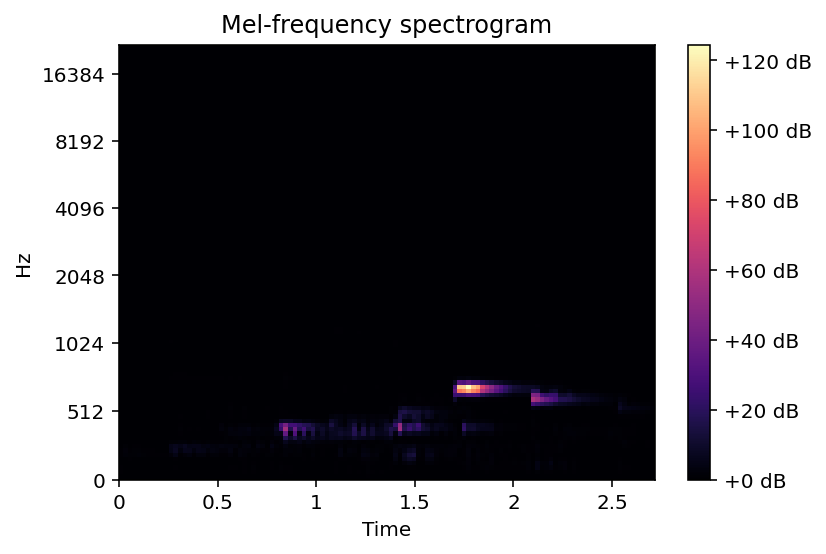

In [10]:
display_mfcc(x['mfcc'].numpy()[0].T)

<h3> Generate predicted sequence for sample from validation set with checkpoint from epoch 1599 ... </h3>

In [11]:
df = reconstruct_audio(model, x)
with pd.option_context('display.max_rows', None):
    print(df)

     label  prediction
0       29          11
1       32          12
2     6060          18
3       34          24
4     6048        6060
5       43          25
6       53        6048
7       57          26
8     6067        6060
9       60          27
10    6061          30
11      62          31
12    6046        6067
13      63          32
14      64        6046
15      70          33
16      85        6055
17    6068          34
18      87        6046
19    6065          35
20      88        6067
21    6044          36
22    6060        6046
23      92          37
24      93          38
25      99          40
26     104        6068
27     109          41
28     112        6046
29    6070          42
30    6067        6065
31     114          43
32    6043        6046
33    6058          44
34     119        6070
35     120          45
36     124        6046
37     140          46
38    6056        6058
39     141          47
40    6041        6070
41    6072          48
42     142 

<h3> ... and the corresponding audio ... </h3>

In [12]:
display_audio(model, x)

Ground truth (label)


Prediction
